In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
from scipy.linalg import solve
from scipy.optimize import minimize

In [12]:
def SQP_eq(f,h,df, dh, x_start, eta=0.01, max_iter=1000, tol=1e-6, k=1.0):
    x = np.array(x_start)
    history = []

    for iteration in range(max_iter):
        grad_f = df(x)
        J_h = dh(x)

        h_x = h(x)
        JhJht = J_h @ J_h.T
        rhs = -k @ h_x + J_h @ grad_f
        lambda_ = -solve(JhJht, rhs)
        
        KKT_grad = grad_f + J_h.T@ lambda_
        KKT_gap = np.max([np.linalg.norm(KKT_grad), np.max(np.abs(h_x))])
        history.append((f(x), KKT_gap))

        # Update x
        x_new = x - eta * (grad_f + J_h.T @ lambda_)
        
        if np.linalg.norm(x_new - x) < tol:
            break
            
        x = x_new  
        
    return x, f(x), history

def SQP_momentum_eq(f,h,df, dh, x_start, eta=0.01, max_iter=1000, tol=1e-6, k=1.0, beta = 0.8):
    x = np.array(x_start)
    history = []
    y = x

    for iteration in range(max_iter):
        grad_f = df(y)
        J_h = dh(y)

        h_x = h(y)
        JhJht = J_h @ J_h.T
        rhs = -k @ h_x + J_h @ grad_f
        lambda_ = -solve(JhJht, rhs)
        
        KKT_grad = grad_f + J_h.T@ lambda_
        KKT_gap = np.max([np.linalg.norm(KKT_grad), np.max(np.abs(h_x))])
        history.append((f(y), KKT_gap))

        x_new = y - eta * (grad_f + J_h.T @ lambda_)

        if np.linalg.norm(x_new - x) < tol:
            break

        x_old = x
        x = x_new
        y = x + beta*(x - x_old)
        
    return x, f(x), history


def SQP_ineq(f,h,df, dh, x_start, K, eta=0.01, max_iter=1000, tol=1e-6, hessian = False):
    x = np.array(x_start)
    history = []
    if not hessian:
        for iteration in range(max_iter):
            grad_f = df(x)
            J_h = dh(x)
            h_x = h(x)
            lambda_ = solve_lambda(J_h, grad_f, h_x, K)
            
            KKT_grad = grad_f + J_h.T@ lambda_
            KKT_gap = np.max([np.linalg.norm(KKT_grad), np.abs(lambda_@h_x), np.max([np.max(h_x),0])])
            history.append((f(x), KKT_gap))
            
            x_new = x - eta * (grad_f +  J_h.T @ lambda_)

            if np.linalg.norm(x_new - x) < tol:
                break
            x = x_new
        return x, f(x), history
    else:
        for iteration in range(max_iter):
            grad_f = df(x)
            J_h = dh(x)
            h_x = h(x)
            H_x = hessian(x)

            lambda_ = solve_lambda(J_h, grad_f, h_x, K, H_x)
            
            KKT_grad = grad_f + J_h.T@ lambda_
            KKT_gap = np.max([np.linalg.norm(KKT_grad), np.abs(lambda_@h_x), np.max([np.max(h_x),0])])
            history.append((f(x), KKT_gap))
            
            
            x_new = x - eta * np.linalg.solve(H_x, grad_f + J_h.T @ lambda_)

            if np.linalg.norm(x_new - x) < tol:
                break
            x = x_new
        return x, f(x), history



def SQP_momentum_ineq(f,h,df, dh, x_start, K, eta=0.01, max_iter=1000, tol=1e-6, beta = 0.8):
    x = np.array(x_start)
    history = []
    y=x
    for iteration in range(max_iter):
        grad_f = df(y)
        J_h = dh(y)
        h_x = h(y)
        lambda_ = solve_lambda(J_h, grad_f, h_x, K)
        
        KKT_grad = grad_f + J_h.T@ lambda_
        KKT_gap = np.max([np.linalg.norm(KKT_grad), np.abs(lambda_@h_x), np.max([np.max(h_x),0])])
        history.append((f(x), KKT_gap))
        
        # kh=K@h(x)
        # kh = kh.squeeze()
        # Jhgrad_f = np.dot(J_h, grad_f)
        x_new = y - eta * (grad_f +  J_h.T @ lambda_)

        if np.linalg.norm(x_new - x) < tol:
            break
        
        x_old = x
        x = x_new
        y = x + beta*(x - x_old)
        
    return x, f(x), history


def solve_lambda(J_h, grad_f, h_x, K, H_x=None):
    if H_x is None:
        m = J_h.shape[0]
        model = gp.Model()
        model.setParam('OutputFlag', 0)  # Suppress output

        # Decision variables
        lambda_ = model.addMVar(shape=m, name="lambda", lb=0.0)

        # Objective: 0.5 * lambda.T * J_h * J_h.T * lambda + lambda.T * J_h * grad_f - lambda.T * K * h_x
        
        J_h_J_hT = J_h @ J_h.T 
        J_h_grad_f = J_h@grad_f
        K_h_x = K @ h_x

        model.setObjective(0.5*lambda_@J_h_J_hT@lambda_ + (J_h_grad_f-K_h_x)@lambda_, GRB.MINIMIZE)
        model.optimize()
        if not model.status == GRB.OPTIMAL:
            print('flag')
        # Retrieve lambda values
        return lambda_.X#np.array([lambda_[i].X for i in range(m)])
    else:
        m = J_h.shape[0]
        model = gp.Model()
        model.setParam('OutputFlag', 0)  # Suppress output

        # Decision variables
        lambda_ = model.addMVar(shape=m, name="lambda")

        # Objective: 0.5 * lambda.T * J_h * J_h.T * lambda + lambda.T * J_h * grad_f - lambda.T * K * h_x
        invH_J_hT = np.linalg.solve(H_x, J_h.T)
        J_h_J_hT = J_h @ invH_J_hT
        J_h_grad_f = J_h@np.linalg.solve(H_x, grad_f)
        K_h_x = K @ h_x

        model.setObjective(0.5*lambda_@J_h_J_hT@lambda_ + (J_h_grad_f-K_h_x)@lambda_, GRB.MINIMIZE)
        model.optimize()
        if not model.status == GRB.OPTIMAL:
            print('flag')

        # Retrieve lambda values
        return lambda_.X#np.array([lambda_[i].X for i in range(m)])


In [3]:
def SQP_eq_bias(f, h, df, dh, x_start, Kp, Ki=0,  eta=0.01, max_iter=1000, tol=1e-6):
    
    x = np.array(x_start)
    history = []
    Integral = 0

    for iteration in range(max_iter):

        grad_f = df(x)
        J_h = dh(x)
        h_x = h(x)
        # 
        #  for Lagrange multipliers
        JhJht = J_h @ J_h.T
        diagJ = np.diag(JhJht)
        Pcontrol = -Kp @ h_x
        Integral = Integral + h_x
        Icontrol = Ki * Integral
        rhs = Pcontrol +Icontrol + J_h @ grad_f
        lambda_ = -rhs/diagJ
       
        # Compute KKT conditions
        
        KKT_grad = grad_f + J_h.T @ lambda_
        KKT_gap = np.max([np.linalg.norm(KKT_grad),np.max(np.abs(h(x)))])
        history.append((f(x), KKT_gap))

        # Update x
        x_new = x - eta * KKT_grad

        # Check for convergence
        if np.linalg.norm(x_new - x) < tol:
            break

        x = x_new

    return x, history


In [4]:

def PDGD_ineq( f,h ,df, dh, x0, max_iter=100, tol=1e-6, alpha=0.01, beta=0.01):
    """
    Primal-Dual Gradient Descent (PDGD) for inequality constraints.

    Parameters:
        f: callable
            Objective function f(x).
        grad_f: callable
            Gradient of the objective function ∇f(x).
        g: callable
            Inequality constraint function g(x) <= 0.
        grad_g: callable
            Gradient of the inequality constraint ∇g(x).
        x0: ndarray
            Initial guess for the primal variables.
        lambda0: ndarray
            Initial guess for the dual variables (Lagrange multipliers).
        max_iter: int
            Maximum number of iterations.
        tol: float
            Tolerance for convergence.
        alpha: float
            Step size for the primal gradient descent.
        beta: float
            Step size for the dual gradient ascent.

    Returns:
        x: ndarray
            Solution vector for the primal variables.
        lambdas: ndarray
            Solution vector for the dual variables (Lagrange multipliers).
        success: bool
            Whether the algorithm converged.
    """
    x = x0
    lambdas = np.zeros(len(h(x0)))
    history = []

    for i in range(max_iter):
        # Compute gradients
        grad_f = df(x)
        J_h = dh(x)
        h_x = h(x)
        grad_primal = grad_f +  J_h.T @ lambdas
        grad_dual = h_x

        KKT_grad = grad_primal
        KKT_gap = np.max([np.linalg.norm(KKT_grad), np.abs(lambdas@h_x), np.max([np.max(h_x),0])])
        history.append((f(x), KKT_gap))


        # Update primal variables (gradient descent)
        x_new = x - alpha * grad_primal

        # Update dual variables (gradient ascent with projection to positive orthant)
        lambdas_new = np.maximum(0, lambdas + beta * grad_dual)

        # Check for convergence
        if np.linalg.norm(x_new - x) < tol and np.linalg.norm(lambdas_new - lambdas) < tol:
            return x_new, lambdas_new, history

        # Update variables for the next iteration
        x = x_new
        lambdas = lambdas_new

        

    return x, f(x), history  # Did not converge within max_iter

In [5]:
def augmented_lagrangian_ineq(f, h, df, dh, x0, max_iter=1000, tol=1e-6, rho=1.0, rho_max=10, rho_increase=1.01, alpha=0.01):
    """
    Solves constrained optimization problems with inequality constraints using the Augmented Lagrangian method.

    Parameters:
        f: callable
            Objective function f(x).
        h: callable
            Inequality constraint function h(x) <= 0.
        df: callable
            Gradient of the objective function ∇f(x).
        dh: callable
            Gradient of the inequality constraint ∇h(x).
        x0: ndarray
            Initial guess for the solution.
        max_iter: int
            Maximum number of iterations.
        tol: float
            Tolerance for convergence.
        rho: float
            Initial penalty parameter for the Augmented Lagrangian.
        rho_increase: float
            Factor by which rho is increased after each iteration.
        alpha: float
            Step size for gradient descent.

    Returns:
        x: ndarray
            Solution vector.
        lambdas: ndarray
            Lagrange multipliers for the inequality constraints.
        history: list
            History of function values and constraint violations.
    """
    x = x0
    lambdas = np.zeros(len(h(x0)),)
    history = []
    # def grad_L_aug(x):
    #     h_x = h(x)
    #     grad_f_x = df(x)
    #     J_h_x = dh(x)
    #     penalty_term = rho * np.maximum(0, h_x)
    #     return grad_f_x + J_h_x.T @ (lambdas + penalty_term)

    for iteration in range(max_iter):
        # Augmented Lagrangian function
        # def L_aug(x):
        #     h_x = h(x)
        #     return f(x) + lambdas @ h_x + (rho / 2) * np.sum(np.maximum(0, h_x)**2)

        # Gradient of the Augmented Lagrangian
        

        # Gradient descent step
        h_x = h(x)
        grad_f_x = df(x)
        J_h_x = dh(x)
        penalty_term = rho * np.maximum(0, h_x)

        grad = grad_f_x + J_h_x.T @ (lambdas + penalty_term)
        
        grad_primal = grad_f_x +  J_h_x.T @ lambdas
        KKT_grad = grad_primal
        KKT_gap = np.max([np.linalg.norm(KKT_grad), np.abs(lambdas@h_x), np.max([np.max(h_x),0])])
        history.append((f(x), KKT_gap))

        x_new = x - alpha * grad

        # Update Lagrange multipliers
        lambdas = np.maximum(0, lambdas + rho * h_x)

        # Check for convergence
        constraint_violation = np.max(np.maximum(0, h_x))
        

        if constraint_violation < tol and KKT_gap < tol:
            return x_new, lambdas, history

        # Update penalty parameter
        rho *= rho_increase
        x = x_new

    return x, lambdas, history  # Did not converge within max_iter

In [6]:
import os

def plot_optimization_history(*Histories,optimal_value=None,legends=None,linewidth=1,fontsize=20,ticksize=15,legendsize=15,savename=None):
    """
    Plots the function values and constraint violations over iterations from optimization history.
    
    Parameters:
    - history: List of tuples (function_value, constraint_violation) representing history of optimization.
    - optimal_value: Optional, the optimal value of the objective function f(x). If provided, adds a reference line.
    """
    
    
    # Plotting
    plt.figure(figsize=(14, 5))
    if optimal_value is not None:
        plt.subplot(1, 2, 1)
        plt.axhline(optimal_value, color='g', linestyle='--', label='Optimal $f(x)$',linewidth=linewidth)
    for i, history in enumerate(Histories):
        label = legends[i] if legends is not None and i < len(legends) else None   
        f_values, h_violations = zip(*history)
        N = len(f_values)
        k = N//5
        plt.subplot(1, 2, 1)
        plt.plot(f_values, label=label,linewidth=linewidth)
        plt.xlabel('Iteration',fontsize=fontsize)
        plt.ylabel('$f(x)$',fontsize=fontsize)
        plt.legend(fontsize=legendsize)
        plt.title('Function Value over Iterations',fontsize=fontsize)
        plt.grid(True)
        plt.xticks(fontsize=ticksize)
        plt.xticks(range(0, N+1, k))
        plt.yticks(fontsize=ticksize)

        # Plot constraint violations
        plt.subplot(1, 2, 2)
        plt.plot(h_violations, label=label,linewidth=linewidth)
        #plt.axhline(0, color='g', linestyle='--', label='Zero Constraint Violation')
        plt.xlabel('Iteration',fontsize=fontsize)
        plt.ylabel('KKT-gap',fontsize=fontsize)
        plt.yscale('log')
        plt.legend(fontsize=legendsize)
        plt.title('KKT Gap over Iterations',fontsize=fontsize)
        plt.grid(True)
        plt.xticks(fontsize=ticksize)
        plt.xticks(range(0, N+1, k))
        plt.yticks(fontsize=ticksize)
    plt.tight_layout()
    if savename:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(savename), exist_ok=True)
        plt.savefig(savename, bbox_inches='tight')
    plt.show()
    


def plot_optimization_history_2(*Histories,optimal_value=None,legends=None,linewidth=1,fontsize=20,ticksize=15,legendsize=15,savename=None):
    """
    Plots the function values and constraint violations over iterations from optimization history.
    
    Parameters:
    - history: List of tuples (function_value, constraint_violation) representing history of optimization.
    - optimal_value: Optional, the optimal value of the objective function f(x). If provided, adds a reference line.
    """
    
    
    # Plotting
    plt.figure(figsize=(14, 5))
    if optimal_value is not None:
        plt.subplot(1, 2, 1)
        plt.axhline(optimal_value, color='g', linestyle='--', label='Optimal $f(x)$',linewidth=linewidth)
    for i, history in enumerate(Histories):
        label = legends[i] if legends is not None and i < len(legends) else None   
        f_values, KKT_gaps, h_violations = zip(*history)
        N = len(f_values)
        k = N//5
        plt.subplot(1, 3, 1)
        plt.plot(f_values, label=label,linewidth=linewidth)
        plt.xlabel('Iteration',fontsize=fontsize)
        plt.ylabel('$f(x)$',fontsize=fontsize)
        plt.legend(fontsize=legendsize)
        plt.title('Function Value over Iterations',fontsize=fontsize)
        plt.grid(True)
        plt.xticks(fontsize=ticksize)
        plt.xticks(range(0, N+1, k))
        plt.yticks(fontsize=ticksize)

        # Plot constraint violations
        plt.subplot(1, 3, 2)
        plt.plot(KKT_gaps, label=label,linewidth=linewidth)
        #plt.axhline(0, color='g', linestyle='--', label='Zero Constraint Violation')
        plt.xlabel('Iteration',fontsize=fontsize)
        plt.ylabel('KKT-gap',fontsize=fontsize)
        plt.yscale('log')
        plt.legend(fontsize=legendsize)
        plt.title('KKT Gap over Iterations',fontsize=fontsize)
        plt.grid(True)
        plt.xticks(fontsize=ticksize)
        plt.xticks(range(0, N+1, k))
        plt.yticks(fontsize=ticksize)

        # Plot constraint violations
        plt.subplot(1, 3, 3)
        plt.plot(h_violations, label=label,linewidth=linewidth)
        #plt.axhline(0, color='g', linestyle='--', label='Zero Constraint Violation')
        plt.xlabel('Iteration',fontsize=fontsize)
        plt.ylabel('Constraint Violation',fontsize=fontsize)
        plt.yscale('log')
        plt.legend(fontsize=legendsize)
        plt.title('KKT Gap over Iterations',fontsize=fontsize)
        plt.grid(True)
        plt.xticks(fontsize=ticksize)
        plt.xticks(range(0, N+1, k))
        plt.yticks(fontsize=ticksize)
    plt.tight_layout()
    if savename:
        # Ensure the directory exists
        os.makedirs(os.path.dirname(savename), exist_ok=True)
        plt.savefig(savename, bbox_inches='tight')
    plt.show()
    

In [7]:
n = 100
m = 5
x0 = np.zeros(n)
Q = np.random.randn(n, n)
Q = Q @ Q.T  # Ensure Q is positive definite
c = np.random.randn(n)

# Create a positive definite tensor R
R = np.zeros((n, n, m))
for i in range(m):
    temp = np.random.randn(n, n)
    R[:,:,i] = 1/100*temp @ temp.T  # Ensure each R[:,:,i] is positive definite

A = np.random.randn(m, n)  # Linear part of constraints
b = np.abs(np.random.randn(m))  # Offset of constraints
def f(x):
    return 1/3*np.sum(x**3) + 0.5*x @ Q @ x + c @ x

def h(x):
    h = np.zeros(m)
    for i in range(m):
        R_i = R[:,:,i]
        a_i = A[i,:]
        b_i = b[i]
        h[i] = (0.5*x@R_i@x + a_i@x + b_i)
    return h

def df(x):
    return x@x + Q@x + c
def dh(x):
    Jh = np.zeros((n,m))
    for i in range(m):
        R_i = R[:,:,i]
        a_i = A[i,:]
        Jh[:,i] = (R_i@x + a_i)
    return Jh.T
#     R_i = R[:,:,0].squeeze()
#     a_i = A[0,:].squeeze()
# #         a_i = A[i,:]
#     return R_i@x + a_i

In [22]:
K1 = np.eye(m)
K2 = 1000*np.eye(m)
K3 = 2000*np.eye(m)
_,_, history1 = SQP_eq(f, h, df, dh, x0, k=K1, max_iter=10000, eta = 1e-3,tol = 1e-18)
_,_, history2 = SQP_eq(f, h, df, dh, x0, k=K2, max_iter=10000, eta = 1e-3,tol = 1e-18)
_,_, history3 = SQP_eq(f, h, df, dh, x0, k=K3, max_iter=10000, eta = 1e-3,tol = 1e-18)

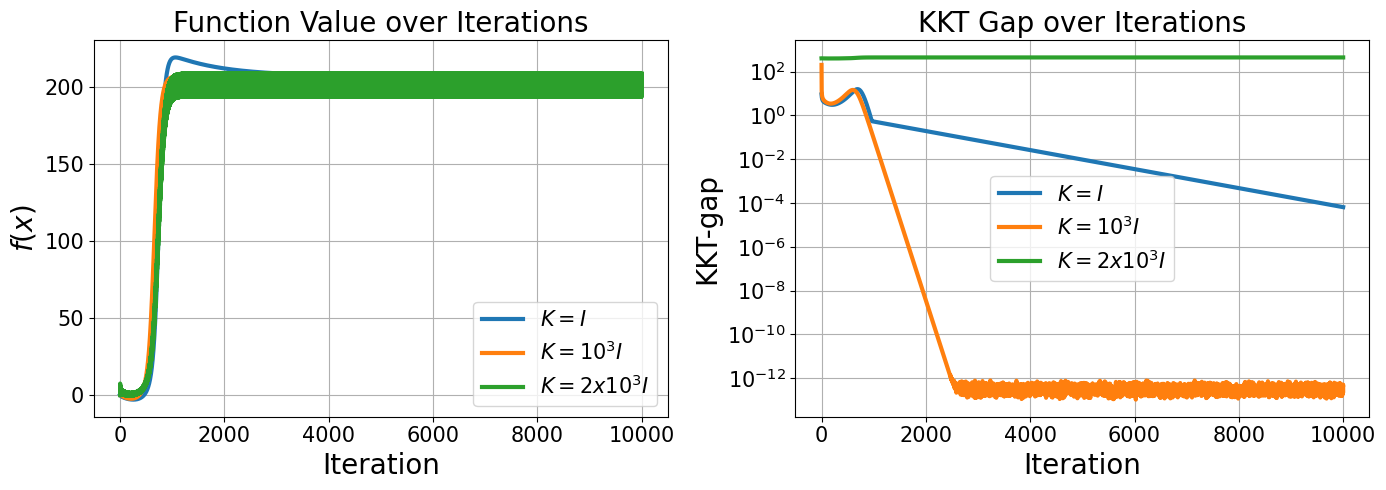

In [23]:
plot_optimization_history(history1, history2,history3,legends = ['$K = I$','$K = 10^3I$','$K=2x10^3 I$'], linewidth=3,savename='FL-diff-K.png')

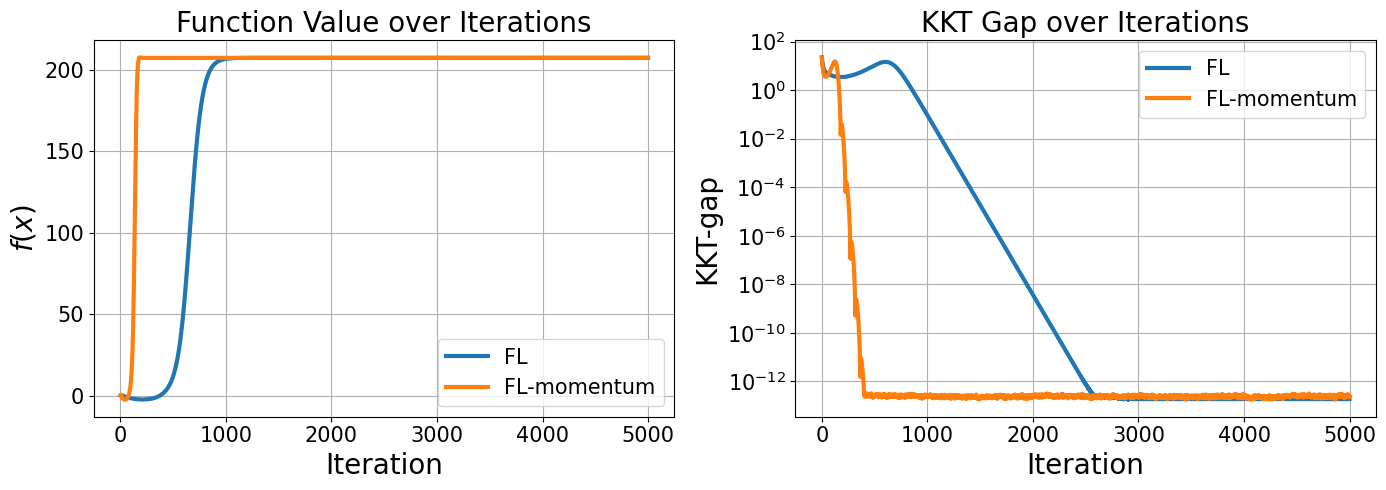

In [24]:
K = 100*np.eye(m)
_,_, history1 = SQP_eq(f, h, df, dh, x0, k=K, max_iter=5000, eta = 1e-3,tol = 1e-18)
_,_, history2 = SQP_momentum_eq(f, h, df, dh, x0, k=K, max_iter=5000, eta = 1e-3,tol = 1e-18)

plot_optimization_history(history1,history2,legends = ['FL', 'FL-momentum'], linewidth=3,savename='FL-eq.png')

In [8]:
n = 100
m = 5
x0 = np.zeros(n)
Q = np.random.randn(n, n)
Q = Q @ Q.T  # Ensure Q is positive definite
c = np.random.randn(n)

# Create a positive definite tensor R
R = np.zeros((n, n, m))
for i in range(m):
    temp = np.random.randn(n, n)
    R[:,:,i] = 1/100*temp @ temp.T  # Ensure each R[:,:,i] is positive definite

A = np.random.randn(m, n)  # Linear part of constraints
b = np.abs(np.random.randn(m))  # Offset of constraints
def f(x):
    return 1/3*np.sum(x**3) + np.sum(x) +0.5*x @ Q @ x + c @ x

def h(x):
    h = np.zeros(m)
    for i in range(m):
        R_i = R[:,:,i]
        a_i = A[i,:]
        b_i = b[i]
        h[i] = (0.5*x@R_i@x + a_i@x + b_i)
    return h

def df(x):
    return x@x + Q@x + c
def dh(x):
    Jh = np.zeros((n,m))
    for i in range(m):
        R_i = R[:,:,i]
        a_i = A[i,:]
        Jh[:,i] = (R_i@x + a_i)
    return Jh.T

FileNotFoundError: [Errno 2] No such file or directory: ''

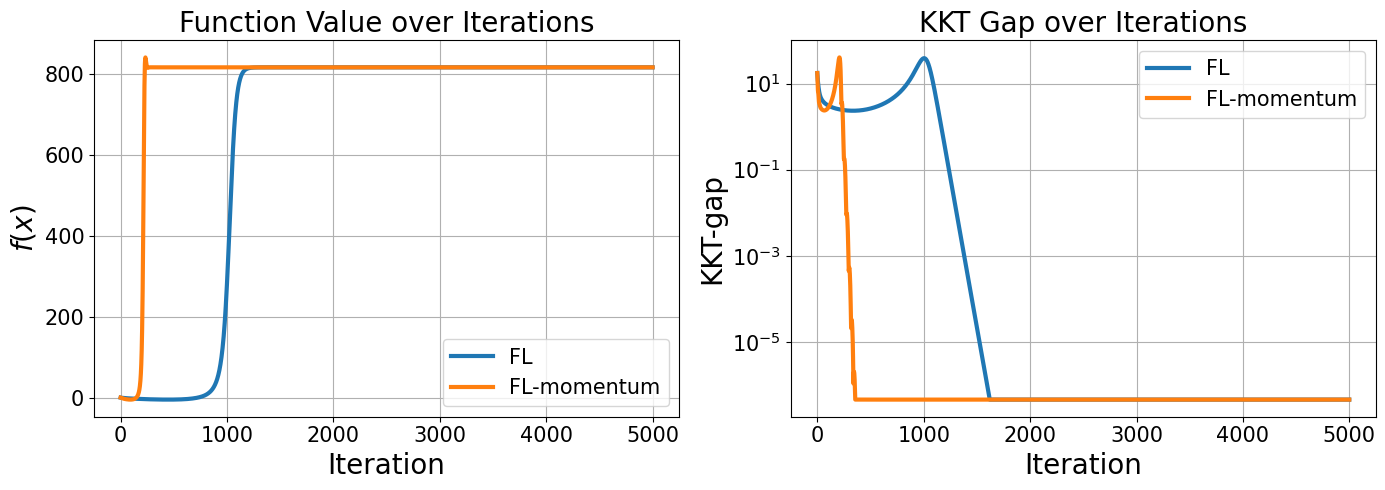

In [13]:
K = 100*np.eye(m)
_,_, history1 = SQP_ineq(f, h, df, dh, x0, K=K, max_iter=5000, eta = 1e-3,tol = 1e-18)
_,_, history2 = SQP_momentum_ineq(f, h, df, dh, x0, K=K, max_iter=5000, eta = 1e-3,tol = 1e-18)

plot_optimization_history(history1,history2,legends = ['FL', 'FL-momentum'], linewidth=3,savename='FL-ineq.png')

In [195]:
from scipy.optimize import approx_fprime

np.random.seed(43)
C = 5
N = [200 for c in range(C)]
nx = 10  # Assuming nx is the dimension of the data points
Dx = []
Dy = []
locs = [np.random.uniform(-1,1) for c in range(C)]

for c in range(C):
    Dcy = []
    Dcx = []
    for i in range(N[c]):
        xi = np.random.normal(loc=locs[c],size=nx)  # sample from normal distribution
        yi = np.random.choice([0, 1])
        Dcx.append(xi)
        Dcy.append(yi)
    Dx.append(Dcx)
    Dy.append(Dcy)

def logistic_loss(Dx, Dy, weights):
    losses = []
    for c in range(C):
        loss = 0
        num_samples = len(Dx[c])
        for i in range(num_samples):
            xi = Dx[c][i]
            yi = Dy[c][i]
            # Logistic loss
            prediction = 1 / (1 + np.exp(-np.dot(weights, xi)))
            if prediction <=0 or prediction >=1:
                print("Alert! Wrong prediction")
            loss += -yi * np.log(prediction) - (1 - yi) * np.log(1 - prediction)
        losses.append(loss / N[c])
    return losses

# losses = logistic_loss(Dx, Dy, weights)
# print(losses)

def gradient_loss(Dx, Dy, weights):
    gradients = []
    for c in range(C):
        grad = np.zeros(nx)
        num_samples = len(Dx[c])
        for i in range(num_samples):
            xi = Dx[c][i]
            yi = Dy[c][i]
            prediction = 1 / (1 + np.exp(-np.dot(weights, xi)))
            error = prediction - yi
            grad += error * xi
        gradients.append(grad / N[c])
    return gradients

def Hessian_loss(Dx, Dy,weights):
    hessian = np.zeros((nx, nx))
    for c in range(C):
        num_samples = len(Dx[c])
        for i in range(num_samples):
            xi = Dx[c][i]
            prediction = 1 / (1 + np.exp(-np.dot(weights, xi)))
            hessian += prediction * (1 - prediction) * np.outer(xi, xi)
    return hessian / sum(N)



In [194]:
def f(x):
    losses = logistic_loss(Dx, Dy, x)
    return np.mean(losses)

def df(x):
    gradients = gradient_loss(Dx, Dy, x)
    return np.mean(gradients, axis=0)
def d2f(x):
    return Hessian_loss(Dx, Dy, x)

def h(x):
    losses = logistic_loss(Dx, Dy, x)
    return np.array(losses) - f(x) #- 0.001#0.07

def dh(x):
    gradients = gradient_loss(Dx, Dy, x)
    return np.array(gradients) - df(x)

In [229]:
def f_sub(x, Dx, Dy):
    losses = logistic_loss(Dx, Dy, x)
    return np.mean(losses)

def df_sub(x, Dx, Dy):
    gradients = gradient_loss(Dx, Dy, x)
    return np.mean(gradients, axis=0)
def d2f_sub(x, Dx, Dy):
    return Hessian_loss(Dx, Dy, x)

def h_sub(x, Dx, Dy):
    losses = logistic_loss(Dx, Dy, x)
    return np.array(losses) - f(x)# - 0.01#0.07

def dh_sub(x, Dx, Dy):
    gradients = gradient_loss(Dx, Dy, x)
    return np.array(gradients) - df_sub(x, Dx, Dy)    

import random

def sub_sample(Dx, Dy, sample_size):
    """
    Subsamples data from Dx and Dy along the N dimension.

    Parameters:
        Dx: list of lists
            Input features, a list of C lists, each containing N samples.
        Dy: list of lists
            Labels, a list of C lists, each containing N samples.
        sample_size: int
            Number of samples to subsample from each class.

    Returns:
        sub_Dx: list of lists
            Subsampled input features.
        sub_Dy: list of lists
            Subsampled labels.
    """
    sub_Dx = []
    sub_Dy = []
    for class_idx in range(len(Dx)):
        indices = random.sample(range(len(Dx[class_idx])), sample_size)
        sub_Dx.append([Dx[class_idx][i] for i in indices])
        sub_Dy.append([Dy[class_idx][i] for i in indices])
    return sub_Dx, sub_Dy
    

In [ ]:
theta0 = np.ones(nx,)
eta = 1e-1
K = 1/eta*np.eye(C)
theta_opt1,_, history1 = SQP_ineq(f, h, df, dh, theta0, K=K, max_iter=300, eta = 2.5*eta,tol = 1e-18)
theta_opt2,_, history2 = SQP_momentum_ineq(f, h, df, dh, theta0, k=K, max_iter=300, eta=1*eta,tol = 1e-18, beta = 0.7)
theta_opt3,_,history3 = SQP_ineq(f, h, df, dh, theta0, K=K, max_iter=300, eta = 2*eta,tol = -1e35, hessian = d2f)
theta_opt4,_,history4 = PDGD_ineq(f, h, df, dh, theta0, max_iter=300,tol = 1e-18,alpha=2*eta, beta=eta)
theta_opt5,_,history5 = augmented_lagrangian_ineq(f, h, df, dh, theta0, max_iter=300, tol=1e-18, rho=1, rho_increase=1.1, alpha=2*eta)

FileNotFoundError: [Errno 2] No such file or directory: ''

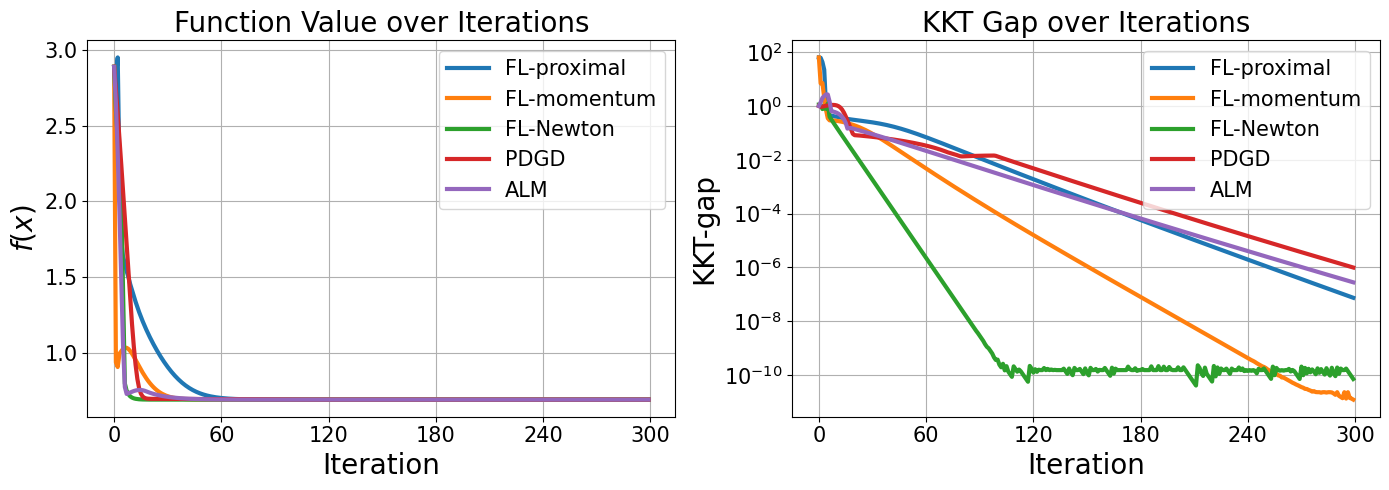

In [29]:
plot_optimization_history(history1, history2,history3,history4, history5, legends = ['FL-proximal', 'FL-momentum','FL-Newton','PDGD','ALM'], linewidth=3,savename='logistic_constrained.png')

In [167]:
theta_opt7,history7 = SQP_eq_bias( f, h, df,dh, theta0, Kp = 3*K, Ki=0,  eta=0.1*eta, max_iter=10000, tol=-1e-18)


In [165]:
theta_opt8,history8 = SQP_eq_bias( f, h, df,dh, theta0, Kp = 3*K, Ki=-5,  eta=0.1*eta, max_iter=10000, tol=-1e-18)


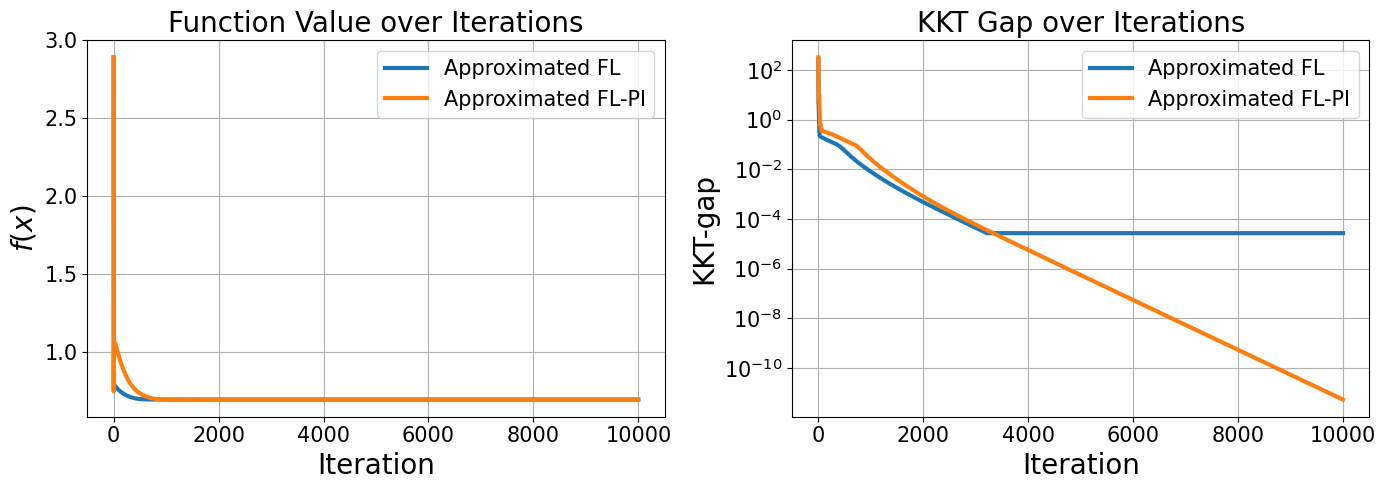

In [168]:

plot_optimization_history(history7,history8,linewidth=3,legends = ['Approximated FL', 'Approximated FL-PI'])

In [101]:
 
 #  Define the dimension of x and A
x_dim = 20
A_dim = (10, x_dim)

# Set random seed for reproducibility
np.random.seed(42)

A = 0.5*np.random.randn(*A_dim) 

# U, _, Vt = np.linalg.svd(A, full_matrices=False)
# A = U @ Vt  # Make A near orthogonal
Q = np.random.randn(x_dim, x_dim)
Q = Q@Q.T   # Ensure Q is positive definite
c = np.random.randn(x_dim,)

b = np.random.randn(A_dim[0],) -10

# Define a quadratic objective function f and its gradient
def f(x):
    return 0.5 * x.T @ Q @ x + c.T @ x

def df(x):
    return Q @ x + c

# Define a linear constraint function h and its Jacobian
def h(x):
    return A @ x - b

def dh(x):
    return A
   

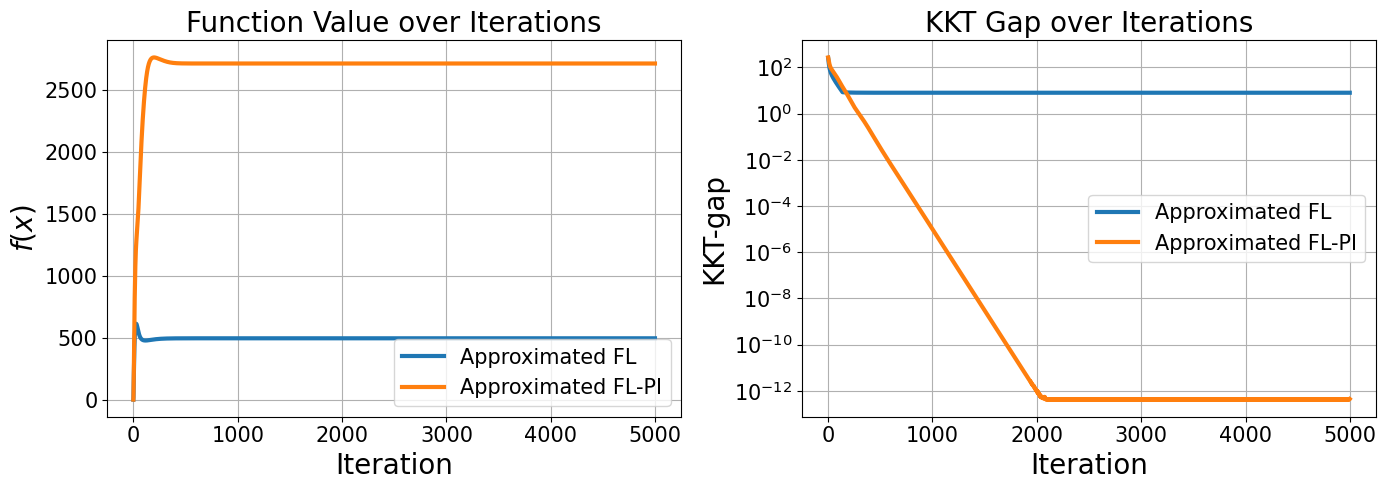

In [102]:
eta = 0.005
x0 = np.zeros(x_dim,)
K = 0.1/eta*np.eye(A_dim[0])
theta_opt7,history7 = SQP_eq_bias( f, h, df,dh, x0, Kp = K, Ki=0,  eta=eta, max_iter=5000, tol=-1e-18)
theta_opt8,history8 = SQP_eq_bias( f, h, df,dh, x0, Kp = K, Ki=-1,  eta=eta, max_iter=5000, tol=-1e-18)
plot_optimization_history(history7,history8,linewidth=3,legends = ['Approximated FL', 'Approximated FL-PI'])

FileNotFoundError: [Errno 2] No such file or directory: ''

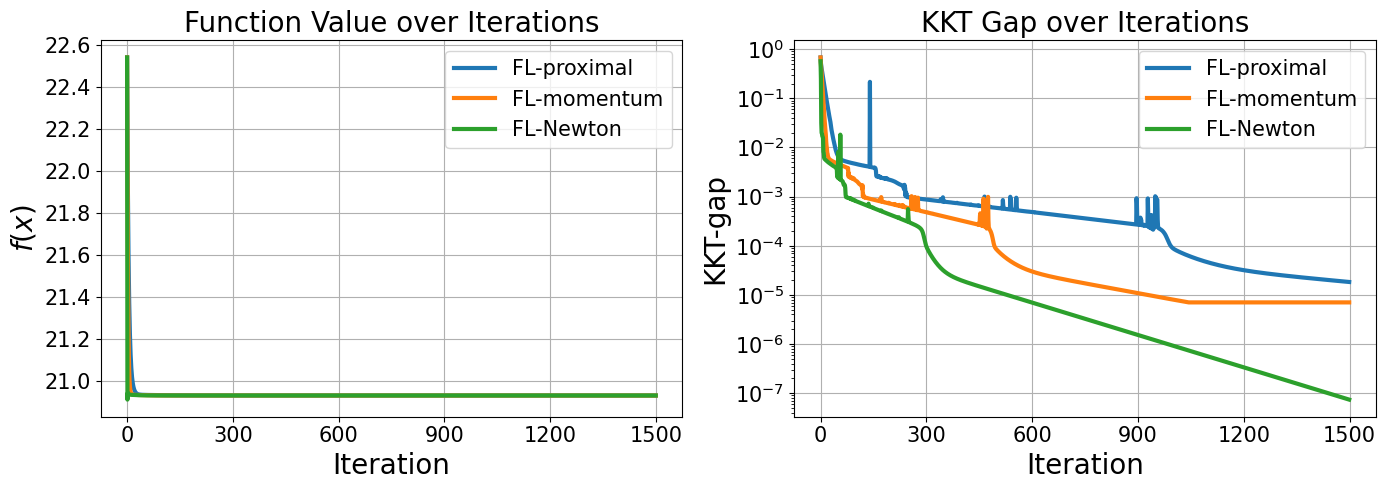

In [17]:
# Upload OPF mat

import scipy.io
import numpy as np
file_path = './OPF/'
mat_file_path = file_path+'case39_history.mat'
mat_file_path_momentum = file_path+'case39_history_momentum.mat'
mat_file_path_newton = file_path+'case39_history_newton.mat'
data_newton = scipy.io.loadmat(mat_file_path_newton)


data = scipy.io.loadmat(mat_file_path)
data_momentum = scipy.io.loadmat(mat_file_path_momentum)

f_vals = np.array(data['f_vals'])
KKT_gaps = np.array(data['KKT_gaps'])
history = zip(f_vals,KKT_gaps)

f_vals_momentum = np.array(data_momentum['f_vals'])
KKT_gaps_momentum = np.array(data_momentum['KKT_gaps'])
history_momentum = zip(f_vals_momentum,KKT_gaps_momentum)

f_vals_newton = np.array(data_newton['f_vals'])
KKT_gaps_newton = np.array(data_newton['KKT_gaps'])
history_newton = zip(f_vals_newton,KKT_gaps_newton)

plot_optimization_history(history,history_momentum,history_newton,legends = ['FL-proximal', 'FL-momentum','FL-Newton'], linewidth=3,savename='OPF_case39.png')



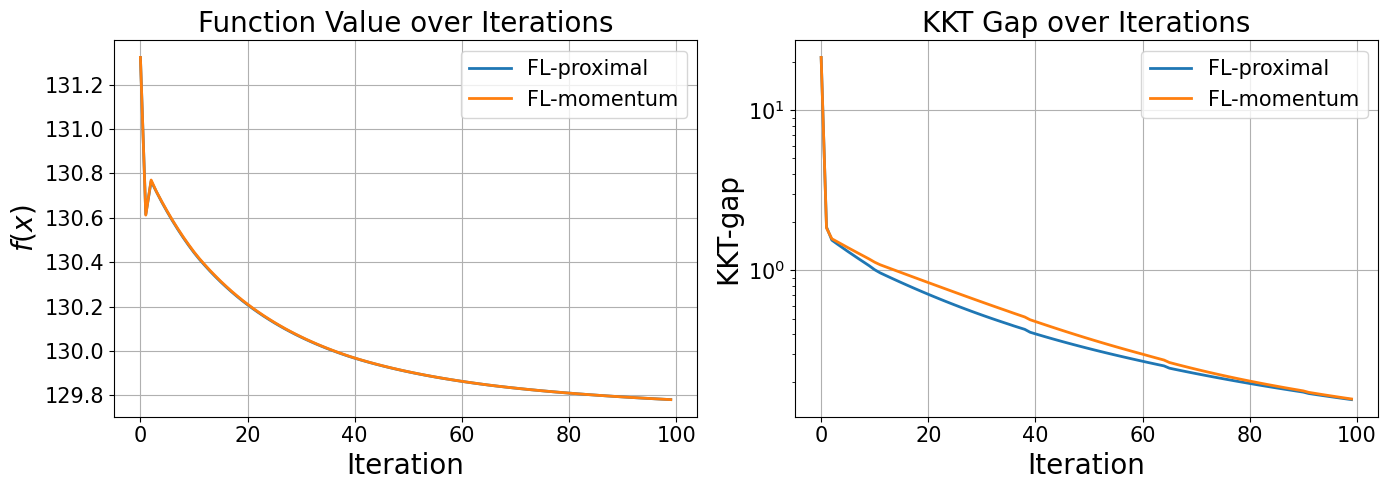

In [18]:
file_path = './OPF/'
mat_file_path = file_path+'case118_history.mat'
mat_file_path_momentum = file_path+'case118_history_momentum.mat'
mat_file_path_newton = file_path+'case118_history_newton.mat'
data = scipy.io.loadmat(mat_file_path)
data_momentum = scipy.io.loadmat(mat_file_path_momentum)
data_newton = scipy.io.loadmat(mat_file_path_newton)

T = 100
f_vals = np.array(data['f_vals'])
KKT_gaps = np.array(data['KKT_gaps'])
history = zip(f_vals[:T],KKT_gaps[:T])

f_vals_momentum = np.array(data_momentum['f_vals'])
KKT_gaps_momentum = np.array(data_momentum['KKT_gaps'])
history_momentum = zip(f_vals_momentum[:T],KKT_gaps_momentum[:T])

f_vals_newton = np.array(data_newton['f_vals'])
KKT_gaps_newton = np.array(data_newton['KKT_gaps'])
history_newton = zip(f_vals_newton[:T],KKT_gaps_newton[:T])

plot_optimization_history(history,history_momentum,legends = ['FL-proximal', 'FL-momentum'], linewidth=2)

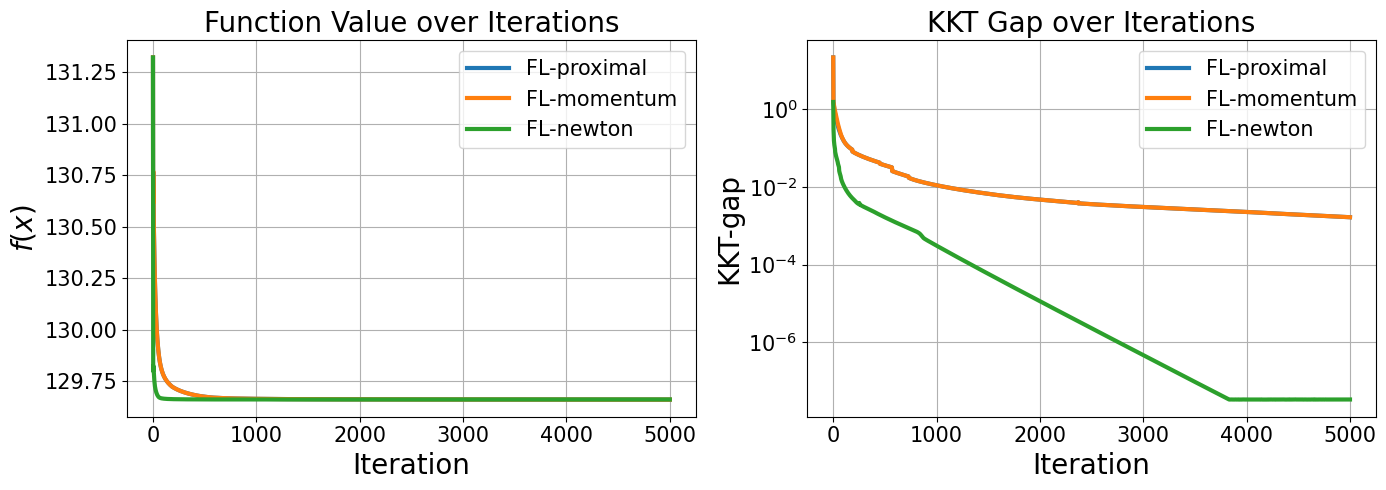

In [19]:
file_path = './OPF/'
mat_file_path = file_path+'case118_history.mat'
mat_file_path_momentum = file_path+'case118_history_momentum.mat'
mat_file_path_newton = file_path+'case118_history_newton.mat'
data = scipy.io.loadmat(mat_file_path)
data_momentum = scipy.io.loadmat(mat_file_path_momentum)
data_newton = scipy.io.loadmat(mat_file_path_newton)

T = 5000
f_vals = np.array(data['f_vals'])
KKT_gaps = np.array(data['KKT_gaps'])
history = zip(f_vals[:T],KKT_gaps[:T])

f_vals_momentum = np.array(data_momentum['f_vals'])
KKT_gaps_momentum = np.array(data_momentum['KKT_gaps'])
history_momentum = zip(f_vals_momentum[:T],KKT_gaps_momentum[:T])

f_vals_newton = np.array(data_newton['f_vals'])
KKT_gaps_newton = np.array(data_newton['KKT_gaps'])
history_newton = zip(f_vals_newton[:T],KKT_gaps_newton[:T])
plot_optimization_history(history,history_momentum,history_newton,legends = ['FL-proximal', 'FL-momentum', 'FL-newton'], linewidth=3)

ValueError: not enough values to unpack (expected 2, got 0)

<Figure size 1400x500 with 0 Axes>

In [120]:
plot_optimization_history(history,history_momentum, legends = ['FL-proximal', 'FL-momentum'], linewidth=1)

ValueError: not enough values to unpack (expected 2, got 0)

<Figure size 1400x500 with 0 Axes>

In [119]:
### Archived code
def SQP_ineq_stochastic(h_stochastic, df_stochastic, dh_stochastic, sub_idx_func, f, h, df, dh, x_start, Kp, Ki=0,  eta=0.01, max_iter=1000, tol=1e-6, k=1.0, beta=0.5):
    """
    Stochastic Sequential Quadratic Programming (SQP) for inequality constraints.

    Parameters:
        f_stochastic: callable
            Stochastic objective function f(x, sub_idx).
        h_stochastic: callable
            Stochastic inequality constraint function h(x, sub_idx) <= 0.
        df_stochastic: callable
            Gradient of the stochastic objective function ∇f(x, sub_idx).
        dh_stochastic: callable
            Gradient of the stochastic inequality constraint ∇h(x, sub_idx).
        x_start: ndarray
            Initial guess for the solution.
        K: ndarray
            Penalty matrix for the constraints.
        sub_idx_func: callable
            Function to generate stochastic sub-indices for sampling.
        eta: float
            Learning rate.
        max_iter: int
            Maximum number of iterations.
        tol: float
            Tolerance for convergence.
        k: float
            Penalty parameter for the constraints.

    Returns:
        x: ndarray
            Solution vector.
        f_val: float
            Final value of the objective function.
        history: list
            History of function values and constraint violations.
    """
    x = np.array(x_start)
    history = []
    Integral = 0
    IntegralJ_h = 0

    for iteration in range(max_iter):
        # Generate stochastic sub-indices
        sub_idx = sub_idx_func(Dy, Dx)

        # Compute gradients and constraints using stochastic functions
        grad_f = df_stochastic(x, sub_idx)
        J_h = dh_stochastic(x, sub_idx)
        h_x = h_stochastic(x, sub_idx)

        IntegralJ_h = beta*IntegralJ_h + (1-beta)*J_h

        # 
        #  for Lagrange multipliers
        JhJht = IntegralJ_h @ IntegralJ_h.T
        Pcontrol = -Kp @ h_x
        Integral = Integral + h_x
        Icontrol = Ki * Integral
        rhs = Pcontrol + Icontrol + IntegralJ_h @ grad_f
        lambda_ = -solve_stochastic(JhJht, rhs)
       
        # Compute KKT conditions
        KKT_grad = df(x) + dh(x).T @ lambda_
        h_x_total = h(x)
        KKT_gap = np.max([np.linalg.norm(KKT_grad), np.abs(lambda_ @ h_x_total), np.max([np.max(h_x_total), 0])])
        history.append((f(x), KKT_gap))

        # Update x
        x_new = x - eta * (grad_f + J_h.T @ lambda_)

        # Check for convergence
        if np.linalg.norm(x_new - x) < tol:
            break

        x = x_new

    return x, history

def solve_stochastic(JhJht, rhs):
    model = gp.Model()
    model.setParam('OutputFlag', 0)  # Suppress output

    # Decision variables
    lambda_ = model.addMVar(shape=JhJht.shape[0], name="lambda", lb=0.0)

    model.setObjective(0.5 * lambda_ @ JhJht @ lambda_ + rhs @ lambda_, GRB.MINIMIZE)
    model.optimize()

    if model.status != GRB.OPTIMAL:
        raise ValueError("Gurobi did not find an optimal solution")

    lambda_ = lambda_.X
    return lambda_

